In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import ot
import os

In [2]:
from OTFramework import LOT

In [3]:
class SDE_General2D(object):
    # parameters :
        # x : (num_cells,) points
        # h : float step size
        # mu : ((num_cells,), float) -> (num_cells,)
        # sigma : ((num_cells,), float) -> (num_cells,)
        # time : float
        # x_bounds : (2,) bounds for cell location

    def __init__(self, x, h, mu, sigma, time, x_bounds=None):
        self.x = x
        self.h = h
        self.mu = mu
        self.sigma = sigma
        self.time = time
        self.x_bounds = x_bounds

        self.num_cells = self.x.shape[0]
        self.num_dim = self.x.shape[1]
    
    def take_step(self,):
        x_step_mu = self.mu(self.x, self.time)
        x_step_sigma = self.sigma(self.x, self.time)
        x_step_delta_w = np.random.multivariate_normal(np.zeros(2), self.h*np.identity(2), size=self.num_cells)
        x_step = x_step_mu*self.h + x_step_sigma*x_step_delta_w
        self.x = self.x + x_step
        
        self.time = self.time + self.h


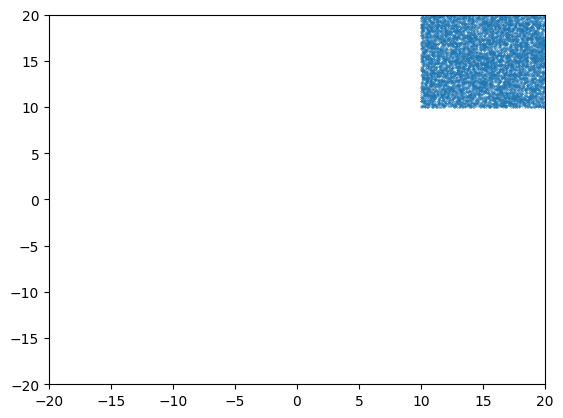

1
143.86299871675743
0.07430049002467241
2
183.40525461096075
0.9797386624066318
3
153.9676939434721
0.21353453135769054
4
243.46842025921848
1.9212985477102953
5
168.31366153225434
0.40872911227662906
6
250.02373717372194
2.613280521300773
7
167.7046215215622
0.49416221622812817
8
205.92271998047053
2.6368579979670446
9
167.1032084603782
0.5031964462039806
10
194.0532301132332
2.6793809616669226
m is 10
Shape of H is (11, 10)
Shape of V is (11, 20000)


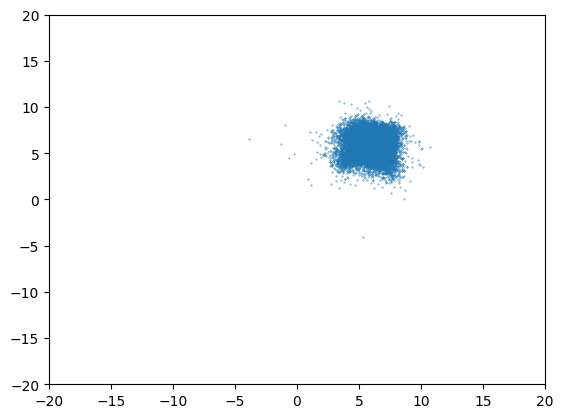

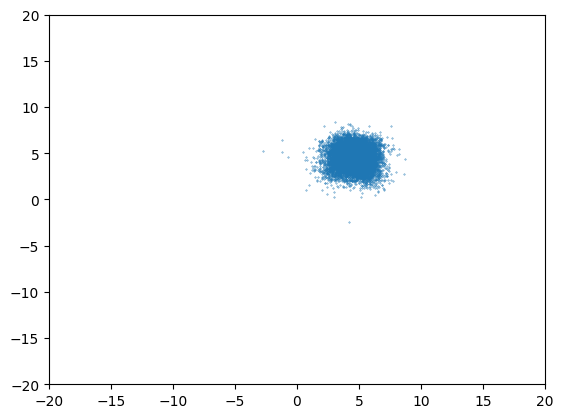

1
143.46823715854813
0.05959651157772825
2
210.10206666837755
1.1926594511352646
3
156.45283149636475
0.10856029645735363
4
246.2246091528184
2.0979611959511546
5
163.37772174490465
0.37880330766147446
6
229.58303371689624
2.7565750218191343
7
162.02912416975164
0.4733772261382765
8
213.15222540604123
2.969178143946234
9
162.28253550094834
0.4433829070154079
10
205.5111624893324
3.004923495469292
m is 10
Shape of H is (11, 10)
Shape of V is (11, 20000)


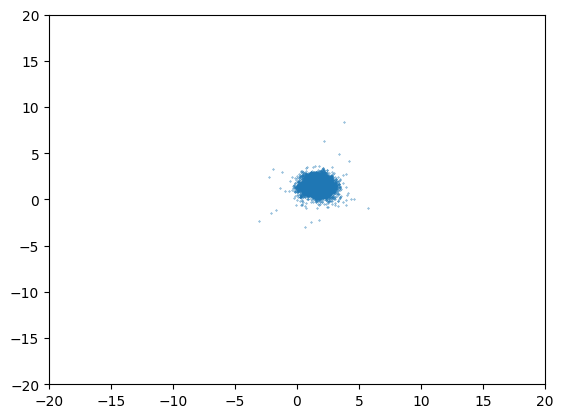

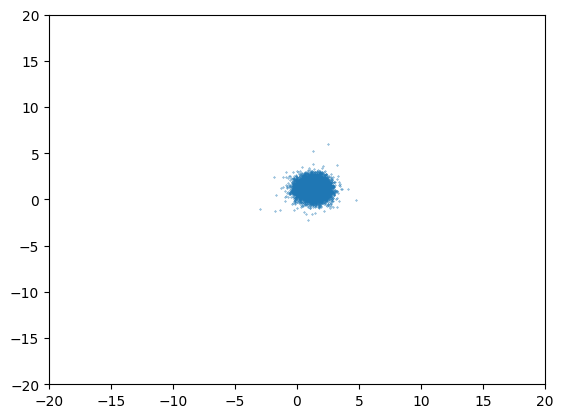

1
145.49286296933323
0.17738885679230518
2
219.98003141057487
1.107405269576872
3
168.14473343301134
0.35446577189692857
4
209.80120206073985
1.4340275912062326
5
172.9360911375681
0.3999007253592602
6
243.67553223350095
1.7002958646258313
7
178.9795113646561
0.49037698520493833
8
285.2349161508981
1.9799603331127407
9
181.0162760081107
0.5409877254090322
10
277.4363600819913
2.030597789905472
m is 10
Shape of H is (11, 10)
Shape of V is (11, 20000)


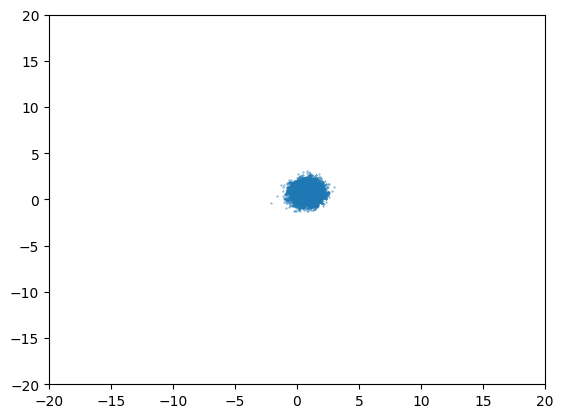

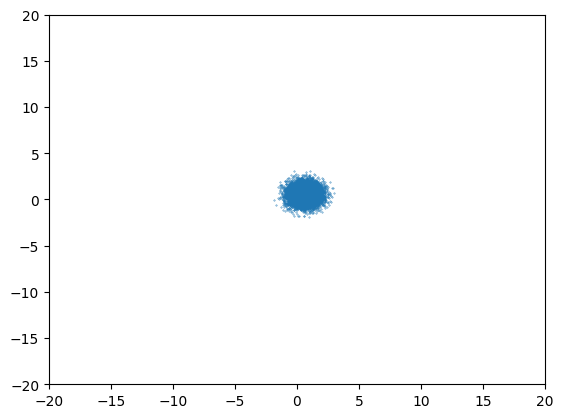

1
152.1523577223085
0.31831158865359793
2
211.47454386370475
0.9977742864363979
3
174.10026888498354
0.5416045210059763
4
195.97116664366575
1.1944003594300654
5
178.8515627265889
0.5670674747187717
6
205.72751262616387
1.3052539832112078
7
181.78697106470574
0.5955967835635385
8
228.4583810444082
1.4193730748286164
9
185.83834382125983
0.6455441008325735
10
249.82950345992714
1.5466437187716413
m is 10
Shape of H is (11, 10)
Shape of V is (11, 20000)


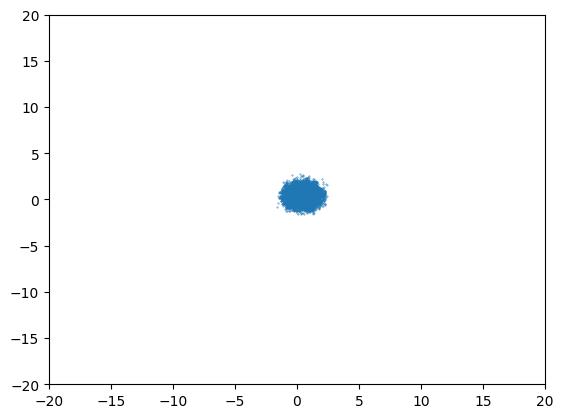

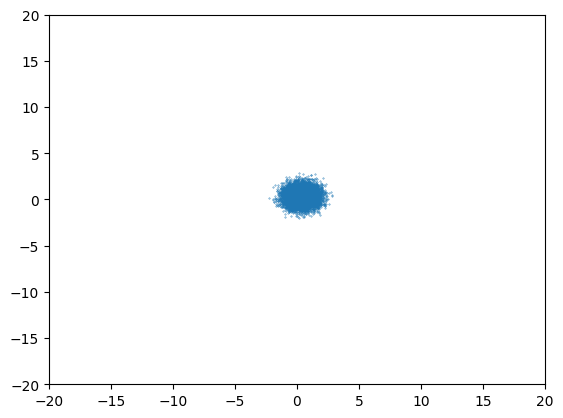

1
166.36246408871764
0.46464793716825314
2
201.83579922935465
0.8575925118051373
3
192.62567805746656
0.6591363106198738
4
188.49909189583965
1.001237245919543
5
199.35374876292911
0.7029792226965227
6
201.0812225231263
1.0863502584065368
7
206.64730034778182
0.7323258427505237
8
217.51821517012246
1.147267193297142
9
210.57308212259215
0.7679319337666543
10
230.82310480168607
1.2956830572085951
m is 10
Shape of H is (11, 10)
Shape of V is (11, 20000)


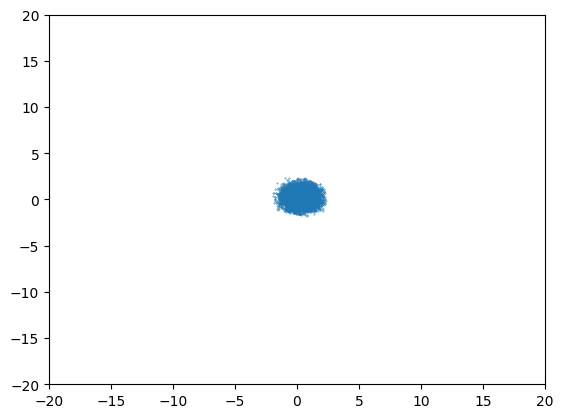

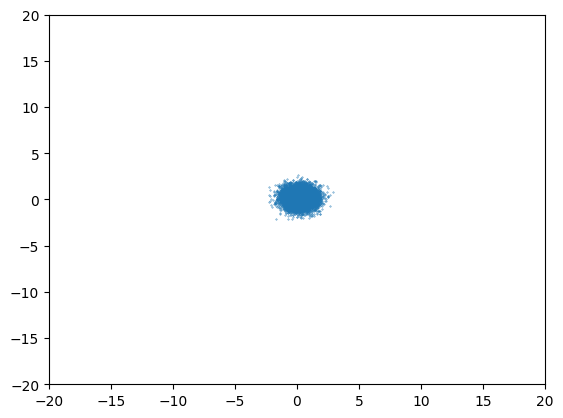

In [9]:
# SDE2D

NUM_PARTS = 10000
H = 1/128

NUM_NEWTON_STEPS = 5
NUM_STEPS_FOR_ORACLE_STEP = 16
NUM_BURNIN_STEPS = 32

NUM_KRYLOV_DIMS = 10

def mu(x,t):
    return -x
def sigma(x,t):
    return 1

x_newton = np.zeros((NUM_NEWTON_STEPS+1, NUM_PARTS, 2))
DOTSIZE = 0.1
XLIM = [-20,20]
YLIM = [-20,20]

krylov_q = np.zeros((NUM_KRYLOV_DIMS+1,NUM_PARTS*2))
krylov_w = np.zeros((NUM_KRYLOV_DIMS,NUM_PARTS*2))
krylov_h = np.zeros((NUM_KRYLOV_DIMS+1,NUM_KRYLOV_DIMS))

x_start_init = np.random.uniform(10,20,size=(NUM_PARTS,2))
x_start = x_start_init
sde1 = SDE_General2D(x_start, H, mu, sigma, 0)

lot1 = LOT(x_start, x_start, max_num_iter=1000000)

x_newton[0] = x_start
plt.figure()
plt.scatter(*x_newton[0].T, s=DOTSIZE)
plt.xlim(XLIM)
plt.ylim(YLIM)
plt.show()

for k in range(NUM_NEWTON_STEPS):
    for n in range(NUM_STEPS_FOR_ORACLE_STEP):
        sde1.take_step()
    lot1.x_tar = sde1.x
    x_after_one_oracle_step = lot1.calc_ot_map()
    
    b = -(x_after_one_oracle_step - x_start).flatten()
    beta = np.linalg.norm(b)
    krylov_q[0] = b/beta

    for j in range(NUM_KRYLOV_DIMS):
        print(j+1)
        DELTA = 1/np.average(np.abs(krylov_q[j]))
        print(DELTA)
        x_start_perturbed = x_start + DELTA*krylov_q[j].reshape(NUM_PARTS,2)
        sde1.x = x_start_perturbed
        for n in range(NUM_STEPS_FOR_ORACLE_STEP):
            sde1.take_step()
        lot1.x_tar = sde1.x
        x_after_one_oracle_step_perturbed = lot1.calc_ot_map()
        krylov_w[j] = (x_after_one_oracle_step_perturbed - x_after_one_oracle_step).flatten()/DELTA-krylov_q[j]
        for i in range(j+1):
            krylov_h[i,j] = np.dot(krylov_w[j],krylov_q[j])
            krylov_w[j] -= krylov_h[i,j]*krylov_q[i]
        krylov_h[j+1,j] = np.linalg.norm(krylov_w[j])
        print(krylov_h[j+1,j])
        if np.abs(krylov_h[j+1,j])<1e-10:
            m = j+1
            print("BREAKING BECAUSE np.abs(krylov_h[j+1,j]) = " + str(np.abs(krylov_h[j+1,j])))
            krylov_q = krylov_q[0:m]
            krylov_w = krylov_w[0:m]
            krylov_h = krylov_h[0:m+1,0:m]
            break
        krylov_q[j+1] = krylov_w[j]/krylov_h[j+1,j]
    m = j+1
    print("m is " + str(m))
    print("Shape of H is " + str(np.shape(krylov_h)))
    print("Shape of V is " + str(np.shape(krylov_q)))
    y_m = np.linalg.lstsq(krylov_h,beta*np.eye(1,m+1,0).reshape(m+1,), rcond=None)[0]
    
    x_update = (krylov_q[0:m].T@y_m).reshape(NUM_PARTS,2)
    x_next = x_start + x_update

    plt.figure()
    plt.scatter(*x_next.T, s=DOTSIZE)
    plt.xlim(XLIM)
    plt.ylim(YLIM)
    plt.show()
    
    sde1.x = x_next
    for n in range(NUM_BURNIN_STEPS):
        sde1.take_step()
    
    x_start = sde1.x
    x_newton[k+1] = x_start
    lot1.x_ref = x_start

    plt.figure()
    plt.scatter(*x_newton[k+1].T, s=DOTSIZE)
    plt.xlim(XLIM)
    plt.ylim(YLIM)
    plt.show()

